In [2]:
import pandas as pd 
import numpy as np

In [3]:
path = '/Users/ahmadroukain/Desktop/Cours/S2/Empirical methods/Project 2/data_project2.xlsx'
df1 = pd.read_excel(path, sheet_name='SMI_RI_CHF', index_col=0, header=0)
df2 = pd.read_excel(path, sheet_name='SWISS GOVT BOND CHF', index_col=0, header=0)
df3 = pd.read_excel(path, sheet_name='SWISS SHORT TERM DEPOSIT ', index_col=0, header=0)
df = df1.merge(df2, left_index=True, right_index=True)
df = df.merge(df3, left_index=True, right_index=True)
df.rename(columns={'SWISS MARKET (SMI) - TOT RETURN IND': 'SMI', 'SW BENCHMARK 10 YEAR DS GOVT. INDEX - TOT RETURN IND': 'SW10Y', 'SWISS FRANC S/T DEPOSIT (FT/RFV) - MIDDLE RATE': 'SSTD'}, inplace=True)
df.rename_axis('Date', inplace=True)

In [4]:
sRet = df.iloc[53:, :2]
sRet_s = df['SMI'].iloc[53:]
sRet_b = df['SW10Y'].iloc[53:]
sRet = sRet.pct_change().iloc[1:]
sRet_s = sRet_s.pct_change().iloc[1:]
sRet_b = sRet_b.pct_change().iloc[1:]
rf = df['SSTD'].iloc[54:] * (1 / 100) * (1 / 52)
rf_mean = rf.mean()

Question 1.2 :

In [5]:
mu_s = sRet_s.mean()
mu_b = sRet_b.mean()
e = np.ones((2, 1))
vcv = np.cov(sRet_s.to_numpy(), sRet_b.to_numpy())
vcv_i = np.linalg.inv(vcv)
mu = np.array([[mu_s], [mu_b]])
excess_return = mu - (rf_mean * e)
w = vcv_i @ excess_return
w_l2 = w / 2
w_l2_rf = 1 - (e.T @ w_l2)
w_l10 = w / 10
w_l10_rf = 1 - (e.T @ w_l10)
print(w_l2, w_l2_rf) # less averse so you short less
print(w_l10, w_l10_rf)

[[1.21980801]
 [6.12276609]] [[-6.3425741]]
[[0.2439616 ]
 [1.22455322]] [[-0.46851482]]


In [6]:
excess_return_s = sRet_s - rf
excess_return_b = sRet_b - rf
excess_squared_return_s = excess_return_s**2
excess_squared_return_b = excess_return_b**2

In [7]:
ks_test_data_s = sorted((excess_return_s - excess_return_s.mean())/excess_return_s.std())
ks_test_squared_data_s = sorted(((excess_return_s - excess_return_s.mean())/excess_return_s.std())**2)
ks_test_data_b = sorted((excess_return_b - excess_return_b.mean())/excess_return_b.std())
ks_test_squared_data_b = sorted(((excess_return_b - excess_return_b.mean())/excess_return_b.std())**2)

Question 2.1 :

In [8]:
from scipy.stats import kstest
from scipy.stats import norm, chi2
ks_test_s = kstest(ks_test_data_s, norm.cdf)
ks_test_b = kstest(ks_test_data_b, norm.cdf)
ks_test_squared_s = kstest(ks_test_squared_data_s, 'chi2', args=(1,))
ks_test_squared_b = kstest(ks_test_squared_data_b, 'chi2', args=(1,))
print(ks_test_s)
print(ks_test_b)
print(ks_test_squared_s)
print(ks_test_squared_b)

KstestResult(statistic=0.08344177701358513, pvalue=1.037202586843977e-07, statistic_location=-0.3199115959239183, statistic_sign=-1)
KstestResult(statistic=0.05763743692751849, pvalue=0.000664775786782455, statistic_location=-0.4807356386837353, statistic_sign=-1)
KstestResult(statistic=0.13699521168803097, pvalue=4.335769946205363e-20, statistic_location=0.46789026765913855, statistic_sign=1)
KstestResult(statistic=0.1044855428081658, pvalue=7.506421855268264e-12, statistic_location=0.4917798719360888, statistic_sign=1)


In [9]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

test_smi = sm.stats.acorr_ljungbox(excess_return_s, lags=4)
print(test_smi)
test_squared_smi = sm.stats.acorr_ljungbox(excess_squared_return_s, lags=4)
print(test_squared_smi)
test_bond = sm.stats.acorr_ljungbox(excess_return_b, lags=4)
print(test_bond)
test_squared_bond = sm.stats.acorr_ljungbox(excess_squared_return_b, lags=4)
print(test_squared_bond)

     lb_stat     lb_pvalue
1  21.555208  3.437878e-06
2  26.946005  1.408475e-06
3  39.856667  1.142716e-08
4  40.193166  3.947998e-08
      lb_stat     lb_pvalue
1  103.642672  2.423018e-24
2  137.375255  1.476870e-30
3  148.906619  4.535480e-32
4  150.534062  1.564158e-31
    lb_stat  lb_pvalue
1  0.156046   0.692823
2  0.196181   0.906567
3  0.412651   0.937617
4  0.438978   0.979163
     lb_stat     lb_pvalue
1  27.656935  1.448518e-07
2  48.694253  2.667948e-11
3  56.300135  3.624883e-12
4  70.421872  1.848948e-14


Question 2.2 :

In [10]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
y_s = sRet_s.shift(-1).reset_index().drop(columns='Date').iloc[:-1]
x_s = sRet_s.reset_index().drop(columns='Date').iloc[:-1]
X_s = sm.add_constant(x_s)
model = sm.OLS(y_s, X_s)
results_ols_s = model.fit()
epsilon_s = pd.Series(results_ols_s.resid)
results_ols_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SMI   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     22.29
Date:                Thu, 23 May 2024   Prob (F-statistic):           2.62e-06
Time:                        22:40:58   Log-Likelihood:                 2730.3
No. Observations:                1198   AIC:                            -5457.
Df Residuals:                    1196   BIC:                            -5446.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.800      0.072      -0.000       0.003
SMI           -0.1352      0.029     -4.721      0.000      -0.191      -0.079
==============================================================================
Omnibus:                      391.668   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6188.603
Skew:                          -1.073   Prob(JB):                         0.00
Kurtosis:                      13.926   Cond. No.                         40.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
y_b = sRet_b.shift(-1).reset_index().drop(columns='Date').iloc[:-1]
x_b = sRet_b.reset_index().drop(columns='Date').iloc[:-1]
X_b = sm.add_constant(x_b)
model = sm.OLS(y_b, X_b)
results_ols_b = model.fit()
epsilon_b = pd.Series(results_ols_b.resid)
results_ols_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SW10Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1026
Date:                Thu, 23 May 2024   Prob (F-statistic):              0.749
Time:                        22:40:58   Log-Likelihood:                 4259.2
No. Observations:                1198   AIC:                            -8514.
Df Residuals:                    1196   BIC:                            -8504.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.769      0.006       0.000       0.001
SW10Y         -0.0093      0.029     -0.320      0.749      -0.066       0.047
==============================================================================
Omnibus:                       89.278   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.532
Skew:                          -0.003   Prob(JB):                     1.09e-97
Kurtosis:                       5.991   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
from arch import arch_model
model_s = arch_model(epsilon_s*100, vol='GARCH', p=1, q=1)
results_garch_s = model_s.fit()
results_garch_s.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6881.171187689332
Iteration:      2,   Func. Count:     14,   Neg. LLF: 474785.30751702696
Iteration:      3,   Func. Count:     22,   Neg. LLF: 2896.6209389676605
Iteration:      4,   Func. Count:     29,   Neg. LLF: 2730.061496958505
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2662.2009821083384
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2662.192843962199
Iteration:      7,   Func. Count:     46,   Neg. LLF: 2662.1928073410554
Iteration:      8,   Func. Count:     51,   Neg. LLF: 2662.192806524648
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2662.192806524648
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2662.19
Distribution:                  Normal   AIC:                           5332.39
Method:            Maximum Likelihood   BIC:                           5352.74
                                        No. Observations:                 1198
Date:                Thu, May 23 2024   Df Residuals:                     1197
Time:                        22:40:58   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1365  7.042e-02      1.939  5.253e-02 [-1.493e-03,  0.275]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7529      0.283      2.658  7.869e-03 [  0.198,  1.308]
alpha[1]       0.2400  6.633e-02      3.618  2.967e-04 [  0.110,  0.370]
beta[1]        0.6568  8.041e-02      8.168  3.129e-16 [  0.499,  0.814]
========================================================================

Covariance estimator: robust
"""

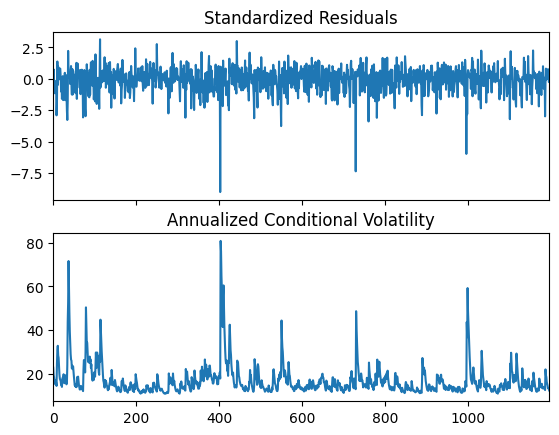

In [13]:
fig_s = results_garch_s.plot(annualize='W')

In [14]:
model_b = arch_model(epsilon_b*100, vol='GARCH', p=1, q=1)
results_garch_b = model_b.fit()
results_garch_b.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5868.2228199863885
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1550805.3726790207
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1340.037235785247
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1322.7402362404746
Iteration:      5,   Func. Count:     39,   Neg. LLF: 1259.403136383575
Iteration:      6,   Func. Count:     46,   Neg. LLF: 1183.8051470771297
Iteration:      7,   Func. Count:     51,   Neg. LLF: 1183.7921286075837
Iteration:      8,   Func. Count:     56,   Neg. LLF: 1183.7920335437757
Iteration:      9,   Func. Count:     61,   Neg. LLF: 1183.7919823085758
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1183.7919817267102
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1183.7919817267102
            Iterations: 10
            Function evaluations: 66
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1183.79
Distribution:                  Normal   AIC:                           2375.58
Method:            Maximum Likelihood   BIC:                           2395.94
                                        No. Observations:                 1198
Date:                Thu, May 23 2024   Df Residuals:                     1197
Time:                        22:40:59   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.0700e-03  1.879e-02     -0.323      0.747 [-4.290e-02,3.076e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0200  1.176e-02      1.702  8.882e-02 [-3.039e-03,4.307e-02]
alpha[1]       0.0938  3.773e-02      2.486  1.292e-02    [1.985e-02,  0.168]
beta[1]        0.8665  5.623e-02     15.410  1.410e-53      [  0.756,  0.977]
=============================================================================

Covariance estimator: robust
"""

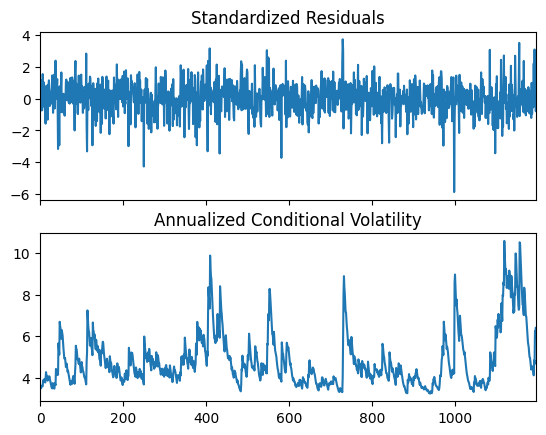

In [15]:
fig_b = results_garch_b.plot(annualize='W')

In [16]:
a_s = results_ols_s.params.iloc[0]
rho_s = results_ols_s.params.iloc[1]
a_b = results_ols_b.params.iloc[0]
rho_b = results_ols_b.params.iloc[1]
mu_s_t1 = a_s + rho_s * sRet_s
mu_s_t1 = mu_s_t1.iloc[:-1]
mu_b_t1 = a_b + rho_b * sRet_b
mu_b_t1 = mu_b_t1.iloc[:-1]
sigma_s_t1 = results_garch_s.conditional_volatility / 100
sigma_s_t1 = sigma_s_t1.shift(1).iloc[1:]
sigma_s_t1.index = mu_s_t1.iloc[1:].index
sigma_b_t1 = results_garch_b.conditional_volatility / 100
sigma_b_t1 = sigma_b_t1.shift(1).iloc[1:]
sigma_b_t1.index = mu_b_t1.iloc[1:].index
epsilon_t1 = pd.DataFrame({'Residuals SMI' : epsilon_s, 'Residuals 10Y' : epsilon_b})
epsilon_t1.index = sRet.iloc[1:].index
corr_epsilon = epsilon_t1.corr()
corr_epsilon = corr_epsilon.iloc[0][1]
sigma_t1 = corr_epsilon * sigma_s_t1 * sigma_b_t1

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/438098644.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corr_epsilon = corr_epsilon.iloc[0][1]


In [17]:
optimal_weights_l2 = []
for i in range(1197):
    vcv_e = np.array([[sigma_s_t1[i]**2, sigma_t1[i]], [sigma_t1[i], sigma_b_t1[i]**2]])
    vcv_e_i = np.linalg.inv(vcv_e)
    mu_e = np.array([[mu_s_t1[i]], [mu_b_t1[i]]])
    excess_return_e = mu_e - (rf.iloc[i] * e)
    w_2 = vcv_e_i @ excess_return_e
    optimal_weights_l2.append(w_2 / 2)
optimal_weights_l10 = []
for i in range(1197):
    vcv_e = np.array([[sigma_s_t1[i]**2, sigma_t1[i]], [sigma_t1[i], sigma_b_t1[i]**2]])
    vcv_e_i = np.linalg.inv(vcv_e)
    mu_e = np.array([[mu_s_t1[i]], [mu_b_t1[i]]])
    excess_return_e = mu_e - (rf.iloc[i] * e)
    w_2 = vcv_e_i @ excess_return_e
    optimal_weights_l10.append(w_2 / 10)
optimal_weights_l2

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/2661260878.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vcv_e = np.array([[sigma_s_t1[i]**2, sigma_t1[i]], [sigma_t1[i], sigma_b_t1[i]**2]])
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/2661260878.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu_e = np.array([[mu_s_t1[i]], [mu_b_t1[i]]])
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/2661260878.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

[array([[ 1.44045965],
        [-0.30454698]]),
 array([[ 0.26613292],
        [-0.50696171]]),
 array([[-2.00340198],
        [-4.11955562]]),
 array([[ 1.04709237],
        [-2.4864177 ]]),
 array([[ 2.17030034],
        [-1.66464659]]),
 array([[3.35015699],
        [1.84191767]]),
 array([[3.07171903],
        [3.11887406]]),
 array([[ 1.88421515],
        [-1.33115118]]),
 array([[ 0.661332  ],
        [-1.67660796]]),
 array([[3.62348592],
        [2.8340696 ]]),
 array([[2.19564056],
        [1.14016771]]),
 array([[-2.169649  ],
        [-4.59132954]]),
 array([[1.50468116],
        [1.17930686]]),
 array([[-1.90475128],
        [-2.25405078]]),
 array([[0.51765854],
        [2.0086879 ]]),
 array([[ 0.32742902],
        [-0.19862822]]),
 array([[-1.31238586],
        [-2.3190726 ]]),
 array([[-2.01455394],
        [-3.24376824]]),
 array([[-1.87770949],
        [-2.48812994]]),
 array([[0.22180799],
        [0.12229091]]),
 array([[3.44461054],
        [0.40993515]]),
 array([

Question 3.2 :

In [18]:
sRet_p_l2 = []
# you have estimators from time 0, so you compute your first weights in 0 until the 22.12.23 where you compute with 29.12.23 returns
for i in range(len(optimal_weights_l2)):
    arr = optimal_weights_l2[i]
    r = arr[0] * sRet_s.iloc[i+1] + arr[1] * sRet_b.iloc[i+1] + (1 - arr[0] - arr[1]) * rf.iloc[i+1]
    r = float(r)
    sRet_p_l2.append(r)
sRet_p_l2 = pd.Series(sRet_p_l2)
sRet_p_l2.index = sRet_b.iloc[2:].index
sRet_p_l2

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/1268208597.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = float(r)


Date
2001-01-26    0.003509
2001-02-02    0.006972
2001-02-09   -0.011712
2001-02-16   -0.019361
2001-02-23   -0.038934
                ...   
2023-12-01   -0.019224
2023-12-08    0.041225
2023-12-15    0.021227
2023-12-22   -0.009038
2023-12-29    0.002917
Length: 1197, dtype: float64

In [19]:
sRet_p_l10 = []
# you have estimators from time 0, so you compute your first weights in 0 until the 22.12.23 where you compute with 29.12.23 returns
for i in range(len(optimal_weights_l10)):
    arr = optimal_weights_l10[i]
    r = arr[0] * sRet_s.iloc[i+1] + arr[1] * sRet_b.iloc[i+1] + (1 - arr[0] - arr[1]) * rf.iloc[i+1]
    r = float(r)
    sRet_p_l10.append(r)
sRet_p_l10 = pd.Series(sRet_p_l10)
sRet_p_l10.index = sRet_b.iloc[2:].index
sRet_p_l10

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/1554960364.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = float(r)


Date
2001-01-26    0.001202
2001-02-02    0.001914
2001-02-09   -0.001804
2001-02-16   -0.003314
2001-02-23   -0.007268
                ...   
2023-12-01   -0.003559
2023-12-08    0.008523
2023-12-15    0.004523
2023-12-22   -0.001522
2023-12-29    0.000869
Length: 1197, dtype: float64

<Axes: xlabel='Date'>

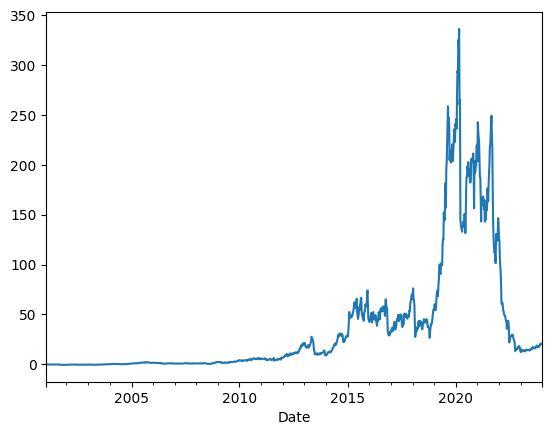

In [20]:
cum_returns_l2 = (1 + sRet_p_l2).cumprod() - 1
cum_returns_l2_log = np.log(1 + sRet_p_l2)
cum_returns_l2_log = cum_returns_l2_log.cumsum()
cum_returns_l2.plot()

<Axes: xlabel='Date'>

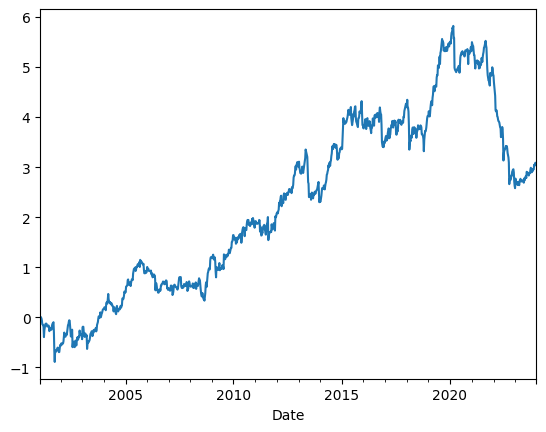

In [21]:
cum_returns_l2_log.plot()

<Axes: xlabel='Date'>

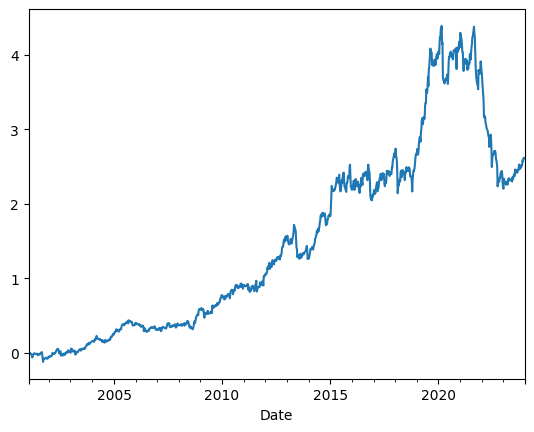

In [22]:
cum_returns_l10 = (1 + sRet_p_l10).cumprod() - 1
cum_returns_l10_log = np.log(1 + sRet_p_l10)
cum_returns_l10_log = cum_returns_l10_log.cumsum()
cum_returns_l10.plot()

<Axes: xlabel='Date'>

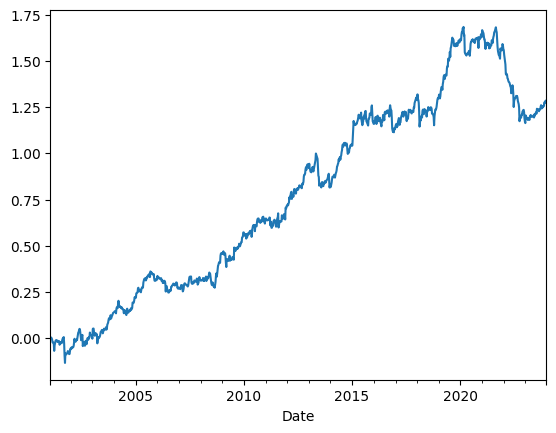

In [23]:
cum_returns_l10_log.plot()

# Question 4

In [24]:
path_daily_data = '/Users/ahmadroukain/Desktop/Cours/S2/Empirical methods/Project 2/daily projet emf.xlsx'

daily_df1 = pd.read_excel(path_daily_data, sheet_name='SMI DAILY', index_col=0, header=0)
daily_df2 = pd.read_excel(path_daily_data, sheet_name='SWISS 10Y', index_col=0, header=0)
daily_df3 = pd.read_excel(path_daily_data, sheet_name='RF', index_col=0, header=0)

In [25]:
# You compute your first portoflio on friday 12-01-2001 so your returns start on monday 15-01-2001

daily_sRet_s = daily_df1.pct_change().iloc[10:]
daily_sRet_b = daily_df2.pct_change().iloc[10:]
daily_rf = daily_df3 / 252 / 100
daily_rf = daily_rf.iloc[10:]

In [26]:
sRet_static_p_l2 = w_l2[0] * daily_sRet_s.values + w_l2[1] * daily_sRet_b.values + (1 - w_l2[0] - w_l2[1]) * daily_rf.values
l = []
for i in sRet_static_p_l2:
    l.append(float(i))
sRet_static_p_l2 = l
sRet_static_p_l10 = w_l10[0] * daily_sRet_s.values + w_l10[1] * daily_sRet_b.values + (1 - w_l10[0] - w_l10[1]) * daily_rf.values
l = []
for i in sRet_static_p_l10:
    l.append(float(i))
sRet_static_p_l10 = l

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/2336749139.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l.append(float(i))
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/2336749139.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l.append(float(i))


In [27]:
sRet_dynamic_p_l2 = []
z = 0
for i in range(len(optimal_weights_l2)): # from 0 to 1200
    arr = optimal_weights_l2[i]
    for t in range(5):
        r = arr[0] * daily_sRet_s.iloc[z + t].values + arr[1] * daily_sRet_b.iloc[z + t].values + (1 - arr[0] - arr[1]) * daily_rf.iloc[z + t].values
        r = float(r)
        sRet_dynamic_p_l2.append(r)
    z += 5

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/1495617472.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = float(r)


In [28]:
sRet_dynamic_p_l10 = []
z = 0
for i in range(len(optimal_weights_l10)): # from 0 to 1200
    arr = optimal_weights_l10[i]
    for t in range(5):
        r = arr[0] * daily_sRet_s.iloc[z + t].values + arr[1] * daily_sRet_b.iloc[z + t].values + (1 - arr[0] - arr[1]) * daily_rf.iloc[z + t].values
        r = float(r)
        sRet_dynamic_p_l10.append(r)
    z += 5


/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/894178579.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = float(r)


In [29]:
sRet_static_p_l2 = pd.Series(sRet_static_p_l2[5:], index=daily_sRet_s.iloc[5:].index)
sRet_static_p_l10 = pd.Series(sRet_static_p_l10[5:], index=daily_sRet_s.iloc[5:].index)
sRet_dynamic_p_l2 = pd.Series(sRet_dynamic_p_l2, index=daily_sRet_s.iloc[5:].index)
sRet_dynamic_p_l10 = pd.Series(sRet_dynamic_p_l10, index=daily_sRet_s.iloc[5:].index)

In [30]:
L_p_t1_st_l2 = -sRet_static_p_l2
L_p_t1_st_l10 = -sRet_static_p_l10
L_p_t1_dyn_l2 = -sRet_dynamic_p_l2
L_p_t1_dyn_l10 = -sRet_dynamic_p_l10

In [31]:
L_p_t1_st_l2_mean = L_p_t1_st_l2.mean()
L_p_t1_st_l10_mean = L_p_t1_st_l10.mean()
L_p_t1_dyn_l2_mean = L_p_t1_dyn_l2.mean()
L_p_t1_dyn_l10_mean = L_p_t1_dyn_l10.mean()
print(f'Mean Dynamic l2 : {L_p_t1_dyn_l2_mean.round(4)}')
print(f'Mean Dynamic l10 : {L_p_t1_dyn_l10_mean.round(4)}')
print(f'Mean static l2 : {L_p_t1_st_l2_mean.round(4)}')
print(f'Mean static l10 : {L_p_t1_st_l10_mean.round(4)}')


Mean Dynamic l2 : -0.0012
Mean Dynamic l10 : -0.0002
Mean static l2 : -0.0009
Mean static l10 : -0.0002


In [32]:
L_p_t1_st_l2_variance = L_p_t1_st_l2.var()
L_p_t1_st_l10_variance = L_p_t1_st_l10.var()
L_p_t1_dyn_l2_variance = L_p_t1_dyn_l2.var()
L_p_t1_dyn_l10_variance = L_p_t1_dyn_l10.var()
print(f'Variance Dynamic l2 : {L_p_t1_dyn_l2_variance.round(4)}')
print(f'Variance Dynamic l10 : {L_p_t1_dyn_l10_variance}')
print(f'Variance static l2 : {L_p_t1_st_l2_variance.round(4)}')
print(f'Variance static l10 : {L_p_t1_st_l10_variance}')

Variance Dynamic l2 : 0.0012
Variance Dynamic l10 : 4.803862393725206e-05
Variance static l2 : 0.0004
Variance static l10 : 1.7372331088336945e-05


In [33]:
theta = 0.99

VaR_st_unc_l2 = norm.ppf(theta, loc=L_p_t1_st_l2_mean, scale=np.sqrt(L_p_t1_st_l2_variance))
VaR_st_unc_l10 = norm.ppf(theta, loc=L_p_t1_st_l10_mean, scale=np.sqrt(L_p_t1_st_l10_variance))
VaR_dyn_unc_l2 = norm.ppf(theta, loc=L_p_t1_dyn_l2_mean, scale=np.sqrt(L_p_t1_dyn_l2_variance))
VaR_dyn_unc_l10 = norm.ppf(theta, loc=L_p_t1_dyn_l10_mean, scale=np.sqrt(L_p_t1_dyn_l10_variance))

VaR_unc = pd.DataFrame({"Dyn_l2":[VaR_dyn_unc_l2],
                        "Dyn_l10":[VaR_dyn_unc_l10],
                        "St_l2":[VaR_st_unc_l2],
                        "St_l10":[VaR_st_unc_l10]})
VaR_unc

,Dyn_l2,Dyn_l10,St_l2,St_l10
0,0.079463,0.015884,0.047598,0.00951


In [34]:
df_l = pd.DataFrame({
    'L_p_t1_dyn_l2': L_p_t1_dyn_l2,
    'L_p_t1_dyn_l10': L_p_t1_dyn_l10,
    'L_p_t1_st_l2': L_p_t1_st_l2,
    'L_p_t1_st_l10': L_p_t1_st_l10
})

In [35]:
garch_dyn_l2 = arch_model(L_p_t1_dyn_l2*100, mean='AR', lags=1, vol="GARCH", p=1, o=0, q=1, power=2, dist="skewt").fit(disp="off")
garch_dyn_l10 = arch_model(L_p_t1_dyn_l10*100, mean='AR', lags=1, vol="GARCH", p=1, o=0, q=1, power=2, dist="skewt").fit(disp="off")
garch_st_l2 = arch_model(L_p_t1_st_l2*100, mean='AR', lags=1, vol="GARCH", p=1, q=1, o=0, power=2, dist="skewt").fit(disp="off")
garch_st_l10 = arch_model(L_p_t1_st_l10*100, mean='AR', lags=1, vol="GARCH", p=1, q=1, o=0, power=2, dist="skewt").fit(disp="off")

In [60]:
print(garch_dyn_l2.params)
print(garch_dyn_l10.params)
print(garch_st_l2.params)
print(garch_st_l10.params)

Const      -0.152564
None[1]     0.007375
omega       1.400019
alpha[1]    0.389074
beta[1]     0.610926
eta         3.372397
lambda      0.009403
Name: params, dtype: float64
Const      -0.032288
None[1]     0.006670
omega       0.055712
alpha[1]    0.388784
beta[1]     0.611216
eta         3.374591
lambda      0.009798
Name: params, dtype: float64
Const      -0.120323
None[1]     0.002894
omega       0.074059
alpha[1]    0.072717
beta[1]     0.909938
eta         6.770097
lambda      0.034553
Name: params, dtype: float64
Const      -0.024566
None[1]     0.002403
omega       0.002968
alpha[1]    0.072923
beta[1]     0.909737
eta         6.741573
lambda      0.033961
Name: params, dtype: float64


In [37]:
mu_dyn_l2 = garch_dyn_l2.params[0]/100 + garch_dyn_l2.params[1]*L_p_t1_dyn_l2
mu_dyn_l10 = garch_dyn_l10.params[0]/100 + garch_dyn_l10.params[1]*L_p_t1_dyn_l10
mu_st_l2 = garch_st_l2.params[0]/100 + garch_st_l2.params[1]*L_p_t1_st_l2
mu_st_l10 = garch_st_l10.params[0]/100 + garch_st_l10.params[1]*L_p_t1_st_l10

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/1568469834.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu_dyn_l2 = garch_dyn_l2.params[0]/100 + garch_dyn_l2.params[1]*L_p_t1_dyn_l2
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/1568469834.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu_dyn_l10 = garch_dyn_l10.params[0]/100 + garch_dyn_l10.params[1]*L_p_t1_dyn_l10
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/1568469834.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/331579253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quantile_99_dyn_l2.append(norm.ppf(theta, loc=mu_dyn_l2[i], scale=garch_dyn_l2.conditional_volatility[i]/100))


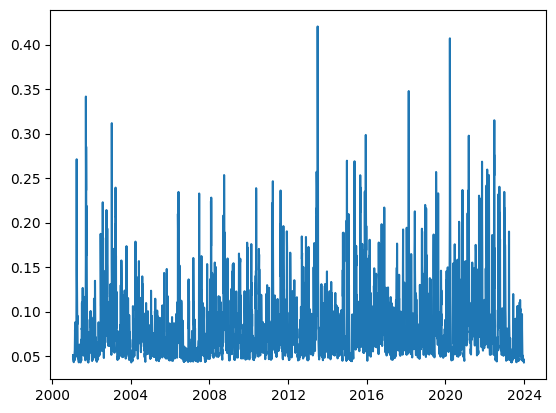

In [38]:
quantile_99_dyn_l2 = []
for i in range(len(mu_dyn_l2[:-1])):
    quantile_99_dyn_l2.append(norm.ppf(theta, loc=mu_dyn_l2[i], scale=garch_dyn_l2.conditional_volatility[i]/100))
quantile_99_dyn_l2 = pd.Series(quantile_99_dyn_l2, index=df_l.iloc[1:].index)
plt.plot(quantile_99_dyn_l2)

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/1556635021.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quantile_99_dyn_l10.append(norm.ppf(theta, loc=mu_dyn_l10[i], scale=garch_dyn_l10.conditional_volatility[i]/100))


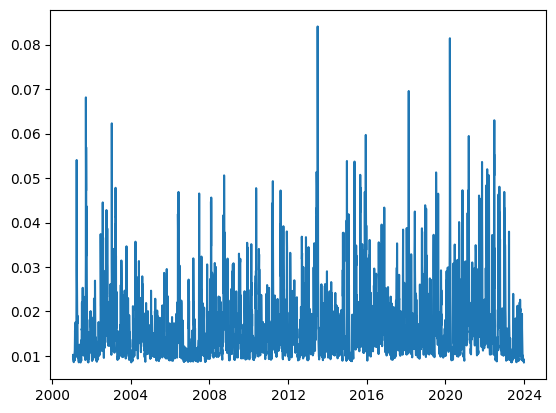

In [39]:
quantile_99_dyn_l10 = []
for i in range(len(mu_dyn_l10[:-1])):
    quantile_99_dyn_l10.append(norm.ppf(theta, loc=mu_dyn_l10[i], scale=garch_dyn_l10.conditional_volatility[i]/100))
quantile_99_dyn_l10 = pd.Series(quantile_99_dyn_l10, index=df_l.iloc[1:].index)
plt.plot(quantile_99_dyn_l10)

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/816594420.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quantile_99_st_l2.append(norm.ppf(theta, loc=mu_st_l2[i], scale=garch_st_l2.conditional_volatility[i]/100))


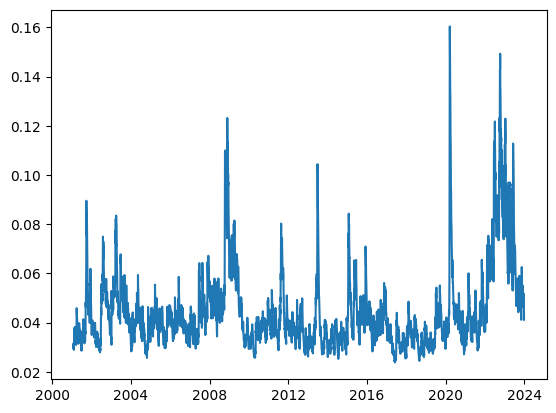

In [40]:
quantile_99_st_l2 = []
for i in range(len(mu_st_l2[:-1])):
    quantile_99_st_l2.append(norm.ppf(theta, loc=mu_st_l2[i], scale=garch_st_l2.conditional_volatility[i]/100))
quantile_99_st_l2 = pd.Series(quantile_99_st_l2, index=df_l.iloc[1:].index)
plt.plot(quantile_99_st_l2)

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_23026/2952366179.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quantile_99_st_l10.append(norm.ppf(theta, loc=mu_st_l10[i], scale=garch_st_l10.conditional_volatility[i]/100))


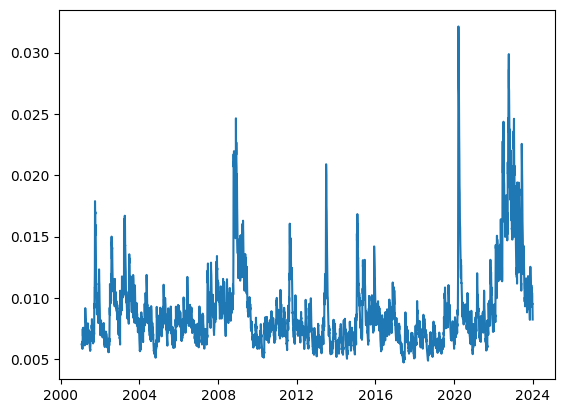

In [41]:
quantile_99_st_l10 = []
for i in range(len(mu_st_l10[:-1])):
    quantile_99_st_l10.append(norm.ppf(theta, loc=mu_st_l10[i], scale=garch_st_l10.conditional_volatility[i]/100))
quantile_99_st_l10 = pd.Series(quantile_99_st_l10, index=df_l.iloc[1:].index)
plt.plot(quantile_99_st_l10)

In [42]:

z_st_l2 = (L_p_t1_st_l2.iloc[1:].values - mu_st_l2.iloc[:-1].values) / (garch_st_l2.conditional_volatility.iloc[1:].values/100)
z_st_l10 = (L_p_t1_st_l10.iloc[1:].values - mu_st_l10.iloc[:-1].values) / (garch_st_l10.conditional_volatility.iloc[1:].values/100)
z_dyn_l2 = (L_p_t1_dyn_l2.iloc[1:].values - mu_dyn_l2.iloc[:-1].values) / (garch_dyn_l2.conditional_volatility.iloc[1:].values/100)
z_dyn_l10 = (L_p_t1_dyn_l10.iloc[1:].values - mu_dyn_l10.iloc[:-1].values) / (garch_dyn_l10.conditional_volatility.iloc[1:].values/100)


In [43]:
z_st_l2 = pd.DataFrame(z_st_l2)
z_st_l10 = pd.DataFrame(z_st_l10)
z_dyn_l2 = pd.DataFrame(z_dyn_l2)
z_dyn_l10 = pd.DataFrame(z_dyn_l10)

In [44]:
sample_start = 0
pred_size = 60
sample_stop = sample_start + 59
pred_start = sample_stop
pred_stop = pred_start + pred_size
ls_windows = [(range(sample_start, sample_stop))]

while pred_stop < len(z_dyn_l2.index):
    sample_start += pred_size
    sample_stop += pred_size
    pred_start += pred_size
    pred_stop = pred_start
    while (pred_stop < len(z_dyn_l2.index)) and (len(range(pred_start, pred_stop)) < pred_size):
        pred_stop += 1
    ls_windows.append((range(sample_start, sample_stop)))

In [45]:
m_dyn_l2 = []
for window in ls_windows:
    subsample = z_dyn_l2.iloc[window]
    x = subsample.max()
    m_dyn_l2.append(x)
m_dyn_l2 = pd.DataFrame(m_dyn_l2)

In [46]:
m_dyn_l10 = []
for window in ls_windows:
    subsample = z_dyn_l10.iloc[window]
    x = subsample.max()
    m_dyn_l10.append(x)
m_dyn_l10 = pd.DataFrame(m_dyn_l10)

In [47]:
m_st_l2 = []
for window in ls_windows:
    subsample = z_st_l2.iloc[window]
    x = subsample.max()
    m_st_l2.append(x)
m_st_l2 = pd.DataFrame(m_st_l2)

In [48]:
m_st_l10 = []
for window in ls_windows:
    subsample = z_st_l10.iloc[window]
    x = subsample.max()
    m_st_l10.append(x)
m_st_l10 = pd.DataFrame(m_st_l10)

In [49]:
df_m = pd.concat([m_dyn_l2, m_dyn_l10, m_st_l2, m_st_l10], axis=1)
df_m.columns = df_l.columns

In [50]:
from scipy.stats import genextreme
df_params_gev = pd.DataFrame()
for column in df_m.columns:
    result = genextreme.fit(df_m[column].iloc[1:])
    print(f'for {column} : {result}')
    df_params_gev[column] = result
# for the first parameters, you have to take the opposite sign
df_params_gev.iloc[0] = df_params_gev.iloc[0] * -1
df_params_gev

for L_p_t1_dyn_l2 : (-0.07251336643159943, 2.282791938070938, 0.7698754619183447)
for L_p_t1_dyn_l10 : (-0.07302577154305459, 2.285169857391555, 0.7715484804674542)
for L_p_t1_st_l2 : (0.01721751287936872, 2.3235508352126013, 0.6001912605294868)
for L_p_t1_st_l10 : (0.017688800641304243, 2.3241576757745452, 0.6006678298932784)


,L_p_t1_dyn_l2,L_p_t1_dyn_l10,L_p_t1_st_l2,L_p_t1_st_l10
0,0.072513,0.073026,-0.017218,-0.017689
1,2.282792,2.285170,2.323551,2.324158
2,0.769875,0.771548,0.600191,0.600668


In [51]:
for column in df_params_gev.columns:
    ksi = df_params_gev[column].iloc[0]
    mu = df_params_gev[column].iloc[1]
    psi = df_params_gev[column].iloc[2]
    q = mu + (psi/ksi)*((-1*np.log(0.99))**(-ksi) - 1)
    q_z = mu + (psi/ksi)*((-60*np.log(0.99))**(-ksi) - 1)
    print(f'quantile {column} : {q}')
    print(f'quantile_z {column} : {q_z}')

quantile L_p_t1_dyn_l2 : 6.486556132086862
quantile_z L_p_t1_dyn_l2 : 2.679427901821834
quantile L_p_t1_dyn_l10 : 6.503314223652977
quantile_z L_p_t1_dyn_l10 : 2.6827195823833647
quantile L_p_t1_st_l2 : 4.978011883963228
quantile_z L_p_t1_st_l2 : 2.6258123120783368
quantile L_p_t1_st_l10 : 4.977886779994652
quantile_z L_p_t1_st_l10 : 2.6266231571749


In [52]:
var_gev_dyn_l2 = 2.661757395531145 * garch_dyn_l2.conditional_volatility.iloc[1:].values/100 - mu_dyn_l2.iloc[:-1].values
var_gev_dyn_l10 = 2.663447446010941 * garch_dyn_l10.conditional_volatility.iloc[1:].values/100 - mu_dyn_l10.iloc[:-1].values
var_gev_st_l2 = 2.623114064304869 * garch_st_l2.conditional_volatility.iloc[1:].values/100 - mu_st_l2.iloc[:-1].values
var_gev_st_l10 = 2.624876310623482 * garch_st_l10.conditional_volatility.iloc[1:].values/100 - mu_st_l10.iloc[:-1].values

In [53]:
var_gev_dyn_l2 = pd.Series(var_gev_dyn_l2, index=df_l.iloc[1:].index)
var_gev_dyn_l10 = pd.Series(var_gev_dyn_l10, index=df_l.iloc[1:].index)
var_gev_st_l2 = pd.Series(var_gev_st_l2, index=df_l.iloc[1:].index)
var_gev_st_l10 = pd.Series(var_gev_st_l10, index=df_l.iloc[1:].index)



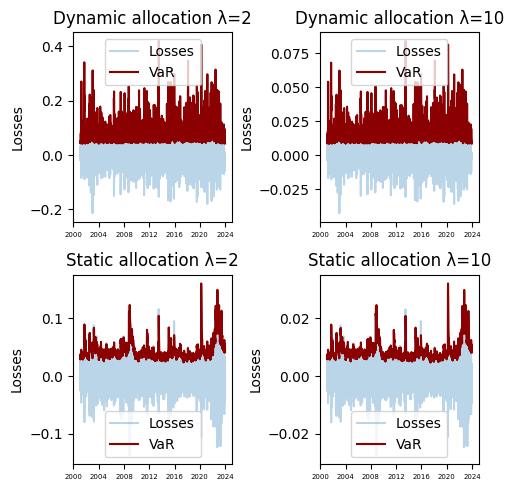

In [54]:
## Graphics
hit_boxes = []
percentages = []

fig, axes = plt.subplots(2, 2, figsize=(5,5))
fig.subplots_adjust(hspace=0.4)

titles = ["Dynamic allocation λ=2", "Dynamic allocation λ=10", "Static allocation λ=2", "Static allocation λ=10"]

for i, ax in enumerate(axes.flat):
    if i == 0:
        losses = L_p_t1_dyn_l2.loc['2001-01-23':]
        var = quantile_99_dyn_l2
        hit_box = np.sum(var < losses)
        percentage = hit_box / len(losses)
        
    elif i == 1:
        losses = L_p_t1_dyn_l10.loc['2001-01-23':]
        var = quantile_99_dyn_l10
        hit_box = np.sum(var < losses)
        percentage = hit_box / len(losses)
        
    elif i == 2:
        losses = L_p_t1_st_l2.iloc[1:]
        var = quantile_99_st_l2
        hit_box = np.sum(var < losses)
        percentage = hit_box / len(losses)
        
    elif i == 3:
        losses = L_p_t1_st_l10.iloc[1:]
        var = quantile_99_st_l10
        hit_box = np.sum(var < losses)
        percentage = hit_box / len(losses)
        
    ax.plot(losses, alpha=0.3, label="Losses")
    ax.tick_params(axis='x', labelsize=5)
    ax.plot(var, color="darkred", label="VaR")
    ax.set_ylabel("Losses")
    ax.set_title(titles[i])
    ax.legend()

    hit_boxes.append(hit_box)
    percentages.append(percentage)

plt.tight_layout()
plt.savefig("GARCH_VaR.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [55]:
# Create a table to store the hit boxes values
table_data = {"Method": titles, "Losses over the VaR": hit_boxes, "Percentage above VaR": percentages}
table = pd.DataFrame(table_data)
latex_table = table.to_latex("garch_var_table.tex", index=False)
print(table)

                    Method  Losses over the VaR  Percentage above VaR
0   Dynamic allocation λ=2                  110              0.018382
1  Dynamic allocation λ=10                  111              0.018549
2    Static allocation λ=2                  103              0.017213
3   Static allocation λ=10                  100              0.016711


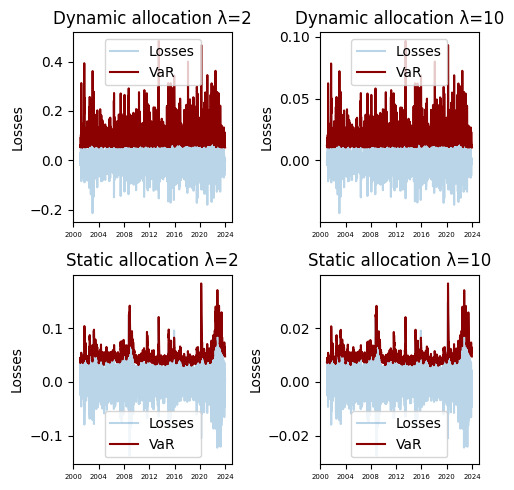

In [56]:
## Graphics
hit_boxes = []
percentages = []

fig, axes = plt.subplots(2, 2, figsize=(5,5))
fig.subplots_adjust(hspace=0.4)

titles = ["Dynamic allocation λ=2", "Dynamic allocation λ=10", "Static allocation λ=2", "Static allocation λ=10"]

for i, ax in enumerate(axes.flat):
    if i == 0:
        losses = L_p_t1_dyn_l2.loc['2001-01-23':]
        var = var_gev_dyn_l2
        hit_box = np.sum(var < losses)
        percentage = hit_box / len(losses)
        
    elif i == 1:
        losses = L_p_t1_dyn_l10.loc['2001-01-23':]
        var = var_gev_dyn_l10
        hit_box = np.sum(var < losses)
        percentage = hit_box / len(losses)
        
    elif i == 2:
        losses = L_p_t1_st_l2.iloc[1:]
        var = var_gev_st_l2
        hit_box = np.sum(var < losses)
        percentage = hit_box / len(losses)
        
    elif i == 3:
        losses = L_p_t1_st_l10.iloc[1:]
        var = var_gev_st_l10
        hit_box = np.sum(var < losses)
        percentage = hit_box / len(losses)
        
    ax.plot(losses, alpha=0.3, label="Losses")
    ax.plot(var, color="darkred", label="VaR")
    ax.tick_params(axis='x', labelsize=5)
    ax.set_ylabel("Losses")
    ax.set_title(titles[i])
    ax.legend()

    hit_boxes.append(hit_box)
    percentages.append(percentage)

plt.tight_layout()
plt.savefig("GEV_VaR.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [57]:
# Create a table to store the hit boxes values
table_data = {"Method": titles, "Losses over the VaR": hit_boxes, "Percentage above VaR": percentages}
table = pd.DataFrame(table_data)
latex_table = table.to_latex("gev_garch_table.tex", index=False)
print(table)

                    Method  Losses over the VaR  Percentage above VaR
0   Dynamic allocation λ=2                   50              0.008356
1  Dynamic allocation λ=10                   49              0.008189
2    Static allocation λ=2                   48              0.008021
3   Static allocation λ=10                   49              0.008189


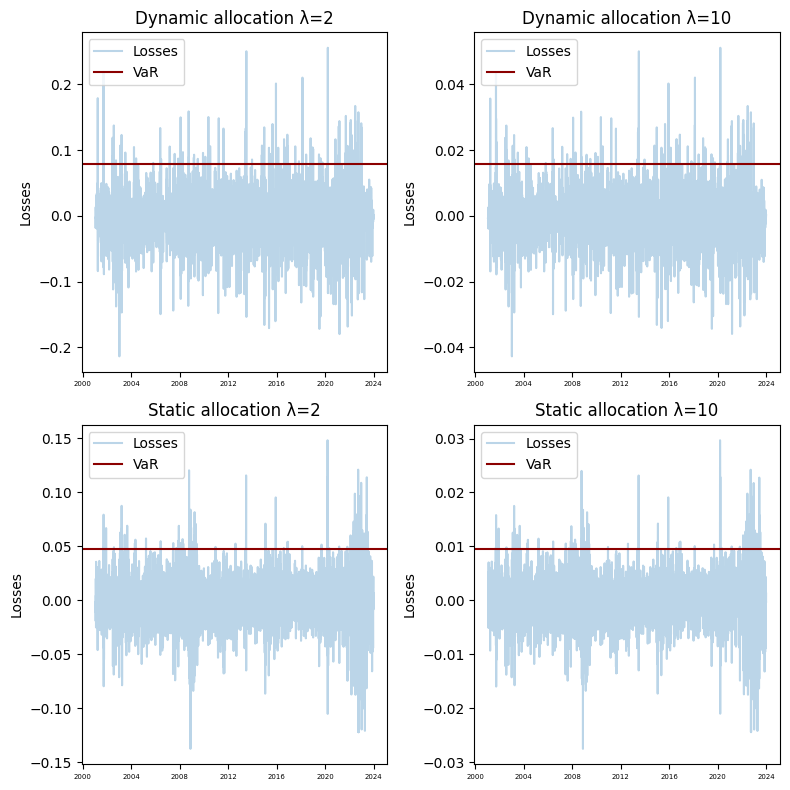

In [58]:
## Graphics
hit_boxes = []
percentages = []

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(hspace=0.4)

titles = ["Dynamic allocation λ=2", "Dynamic allocation λ=10", "Static allocation λ=2", "Static allocation λ=10"]

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(L_p_t1_dyn_l2, alpha=0.3, label="Losses")
        ax.axhline(y=VaR_dyn_unc_l2, color="darkred", linestyle="-", label="VaR")
        hit_boxes.append(np.sum(L_p_t1_dyn_l2 > VaR_dyn_unc_l2))
        percentages.append(hit_boxes[-1] / len(L_p_t1_dyn_l2))
    elif i == 1:
        ax.plot(L_p_t1_dyn_l10, alpha=0.3, label="Losses")
        ax.axhline(y=VaR_dyn_unc_l10, color="darkred", linestyle="-", label="VaR")
        hit_boxes.append(np.sum(L_p_t1_dyn_l10 > VaR_dyn_unc_l10))
        percentages.append(hit_boxes[-1] / len(L_p_t1_dyn_l2))
    elif i == 2:
        ax.plot(L_p_t1_st_l2, alpha=0.3, label="Losses")
        ax.axhline(y=VaR_st_unc_l2, color="darkred", linestyle="-", label="VaR")
        hit_boxes.append(np.sum(L_p_t1_st_l2 > VaR_st_unc_l2))
        percentages.append(hit_boxes[-1] / len(L_p_t1_st_l2))
    elif i == 3:
        ax.plot(L_p_t1_st_l10, alpha=0.3, label="Losses")
        ax.axhline(y=VaR_st_unc_l10, color="darkred", linestyle="-", label="VaR")
        hit_boxes.append(np.sum(L_p_t1_st_l10 > VaR_st_unc_l10))
        percentages.append(hit_boxes[-1] / len(L_p_t1_st_l10))
        
    ax.tick_params(axis='x', labelsize=5)
    ax.set_ylabel("Losses")
    ax.set_title(titles[i])
    ax.legend()

plt.tight_layout()
plt.savefig("VaR_unc.jpg", dpi=200, bbox_inches="tight")
plt.show()

In [59]:
table_data = {"Method": titles, "Losses over the VaR": hit_boxes, "Percentage above VaR": percentages}
table = pd.DataFrame(table_data)
latex_table = table.to_latex("var_unc.tex", index=False)
print(table)

                    Method  Losses over the VaR  Percentage above VaR
0   Dynamic allocation λ=2                  118              0.019716
1  Dynamic allocation λ=10                  119              0.019883
2    Static allocation λ=2                   99              0.016541
3   Static allocation λ=10                   99              0.016541
